In [25]:
import numpy as np
import random
import tensorflow as tf
from tensorflow.keras.layers import (Input, Conv2D, BatchNormalization, Activation, 
                                     MaxPooling2D, Concatenate, Flatten, Dense, Add, 
                                     AveragePooling2D, Dropout)
from PIL import Image
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from sklearn.metrics import (confusion_matrix, roc_curve, auc, 
                             precision_score, recall_score, classification_report)
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2
import copy
from collections import deque
import math
import time

np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

# 1.1 Global Configuration

In [2]:
DEFAULT_HYPERPARAMS = {
    "input_shape": (224, 224, 3),
    "num_classes": 3,
    "learning_rate": 0.0001,
    "epochs": 50,
    "batch_size": 16
}

BASE_PATH = "/kaggle/input/feature-selelcted-dataset"
CATEGORIES = ['normal', 'covid19', 'pneumonia']
IMAGE_SIZE = (DEFAULT_HYPERPARAMS['input_shape'][0], DEFAULT_HYPERPARAMS['input_shape'][1])
LABEL_MAPPING = {'covid19': 0, 'pneumonia': 1, 'normal': 2}
TARGET_NAMES = ['Covid-19', 'Pneumonia', 'Normal']

optimization_summary = {}

# 1. Data Loading and Preprocessing

In [3]:
def load_images(folder, categories, image_size):
    
    images, labels = [], []
    for category in categories:
        category_path = os.path.join(folder, category)
        if not os.path.isdir(category_path):
            print(f"Warning: Directory not found: {category_path}")
            continue
            
        for filename in os.listdir(category_path):
            img_path = os.path.join(category_path, filename)
            try:
                img = cv2.imread(img_path)  # Load in BGR
                if img is not None:
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # Convert to RGB
                    img = cv2.resize(img, image_size)
                    images.append(img)
                    labels.append(category)
            except Exception as e:
                print(f"Error loading {img_path}: {e}")
                
    return np.array(images).astype('float32'), np.array(labels)

In [4]:
def encode_labels(labels, label_mapping, num_classes):
    int_labels = [label_mapping[label] for label in labels]
    return tf.keras.utils.to_categorical(int_labels, num_classes=num_classes).astype('float32')

train_images, train_labels_raw = load_images(
    os.path.join(BASE_PATH, 'train'), CATEGORIES, IMAGE_SIZE
)
test_images_full, test_labels_full_raw = load_images(
    os.path.join(BASE_PATH, 'test'), CATEGORIES, IMAGE_SIZE
)

val_images, test_images, val_labels_raw, test_labels_raw = train_test_split(
    test_images_full, test_labels_full_raw, 
    test_size=0.75, 
    stratify=test_labels_full_raw, 
    random_state=42
)

train_labels = encode_labels(train_labels_raw, LABEL_MAPPING, DEFAULT_HYPERPARAMS['num_classes'])
val_labels = encode_labels(val_labels_raw, LABEL_MAPPING, DEFAULT_HYPERPARAMS['num_classes'])
test_labels = encode_labels(test_labels_raw, LABEL_MAPPING, DEFAULT_HYPERPARAMS['num_classes'])

print(f"Train images shape: {train_images.shape}")
print(f"Validation images shape: {val_images.shape}")
print(f"Test images shape: {test_images.shape}")

Train images shape: (1205, 224, 224, 3)
Validation images shape: (75, 224, 224, 3)
Test images shape: (227, 224, 224, 3)


# 2. Data Augmentation & Generators

## 2.1 Create Data Generators

In [5]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)
val_test_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow(
    x=train_images,
    y=train_labels,
    batch_size=DEFAULT_HYPERPARAMS['batch_size'],
    shuffle=True
)

validation_generator = val_test_datagen.flow(
    x=val_images,
    y=val_labels,
    batch_size=DEFAULT_HYPERPARAMS['batch_size'],
    shuffle=True
)

test_generator = val_test_datagen.flow(
    x=test_images,
    y=test_labels,
    batch_size=DEFAULT_HYPERPARAMS['batch_size'],
    shuffle=False
)

In [6]:
steps_per_epoch = math.ceil(len(train_images) / DEFAULT_HYPERPARAMS['batch_size'])
validation_steps = math.ceil(len(val_images) / DEFAULT_HYPERPARAMS['batch_size'])
test_steps = math.ceil(len(test_images) / DEFAULT_HYPERPARAMS['batch_size'])

# 3. Core Helper Functions (Model & Evaluation)

In [7]:
def build_vgg16_model(input_shape, num_classes, dropout_rate, learning_rate, dense_units):
    """
    Creates the VGG16 model with a custom hyperparameterized classification head.
    This function is used by all optimization algorithms.
    """
    inputs = tf.keras.Input(shape=input_shape, name='input_1')
    weights = 'imagenet'
    weights_path = os.path.expanduser('~/.keras/models/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5')
    if os.path.exists(weights_path):
        weights = weights_path

    base_model = VGG16(weights=weights, include_top=False, input_tensor=inputs)
    base_model.trainable = False

    layer_name_mapping = {
        'block1_conv1': 'Glock1_conv1', 'block1_conv2': 'Glock1_conv2', 'block1_pool': 'Glock1_pool',
        'block2_conv1': 'Glock2_conv1', 'block2_conv2': 'Glock2_conv2', 'block2_pool': 'Glock2_coel',
        'block3_conv1': 'Glock3_conv1', 'block3_conv2': 'Glock3_conv2', 'block3_conv3': 'Glock3_conv3', 'block3_pool': 'Glock3_coel',
        'block4_conv1': 'Glock4_conv1', 'block4_conv2': 'Glock4_conv2', 'block4_conv3': 'Glock4_conv3', 'block4_pool': 'Glock4_coel',
        'block5_conv1': 'Glock5_conv1', 'block5_conv2': 'Glock5_conv2', 'block5_conv3': 'Glock5_conv3', 'block5_pool': 'Glock5_coel'
    }
    for layer in base_model.layers:
        if layer.name in layer_name_mapping:
            layer._name = layer_name_mapping[layer.name]
    
    x = base_model.output
    x = AveragePooling2D(pool_size=(4, 4), name='Avarage_poolZhg8')(x)
    x = Flatten(name='Atsitas')(x)
    
    x = Dense(dense_units, activation='relu', name='Aonte')(x)
    
    x = Dropout(dropout_rate, name='Argoat_dropout')(x)
    outputs = Dense(num_classes, activation='softmax', name='Gonsu_2_softmax')(x)

    model = Model(inputs=inputs, outputs=outputs, name='nCOVnet_Optimized')

    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

In [8]:
def plot_training_history(history, title="Model Training History"):
    """
    Plots accuracy and loss curves for a given Keras history object.
    Returns the max validation accuracy and min validation loss.
    """
    plt.figure(figsize=(12, 5))
    
    # Plot Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'Accuracy - {title}')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'Loss - {title}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

    max_val_acc = max(history.history['val_accuracy'])
    min_val_loss = min(history.history['val_loss'])
    return max_val_acc, min_val_loss

In [17]:
def evaluate_model(model, test_generator, target_names, title="Model Evaluation"):

    print(f"\n--- {title} ---")
    
    # 0. Evaluate model for loss and accuracy
    test_loss, test_accuracy = model.evaluate(test_generator, steps=test_steps, verbose=0)
    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")
    
    # 1. Make predictions
    y_pred_probs = model.predict(test_generator, steps=test_steps)
    y_pred = np.argmax(y_pred_probs, axis=1)
    
    # 2. Get true labels
    # We use test_generator.y which we know is not shuffled
    y_true = np.argmax(test_generator.y, axis=1)
    
    # 3. Print Classification Report
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=target_names))

    # 4. Calculate Sensitivity and Specificity
    cm = confusion_matrix(y_true, y_pred)
    sensitivities, specificities = [], []
    for i in range(len(cm)):
        TP = cm[i, i]
        FN = cm[i, :].sum() - TP
        FP = cm[:, i].sum() - TP
        TN = cm.sum() - (TP + FN + FP)
        
        sensitivity = TP / (TP + FN) if (TP + FN) != 0 else 0
        specificity = TN / (TN + FP) if (TN + FP) != 0 else 0
        sensitivities.append(sensitivity)
        specificities.append(specificity)

    overall_sensitivity = np.mean(sensitivities)
    overall_specificity = np.mean(specificities)
    
    print(f"Overall Sensitivity (macro-averaged) = {overall_sensitivity:.4f}")
    print(f"Overall Specificity (macro-averaged) = {overall_specificity:.4f}")

    # 5. Plot Confusion Matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=target_names, 
                yticklabels=target_names)
    plt.title(f'Confusion Matrix - {title}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    # 6. Plot ROC Curve (One vs Rest)
    fpr, tpr, roc_auc = {}, {}, {}
    n_classes = len(target_names)
    
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(test_generator.y[:, i], y_pred_probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    plt.figure(figsize=(8, 6))
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], label=f'ROC curve ({target_names[i]}) (AUC = {roc_auc[i]:.2f})')
    plt.plot([0, 1], [0, 1], 'k--') 
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic (ROC) - {title}')
    plt.legend(loc='lower right')
    plt.show()
    
    return test_loss, test_accuracy, overall_sensitivity, overall_specificity

# 4. Train the Model

In [10]:
dropout_rate = 0.5
dense_units = 128
learning_rate = DEFAULT_HYPERPARAMS['learning_rate']
epochs = 50
batch_size = DEFAULT_HYPERPARAMS['batch_size']

In [11]:
model = build_vgg16_model(
    input_shape=DEFAULT_HYPERPARAMS['input_shape'],
    num_classes=DEFAULT_HYPERPARAMS['num_classes'],
    dropout_rate=dropout_rate,
    learning_rate=learning_rate,
    dense_units=dense_units
)

I0000 00:00:1765396704.154362      38 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1765396704.155011      38 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [12]:
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=epochs,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    verbose=1
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50


I0000 00:00:1765396708.471813     119 service.cc:148] XLA service 0x781e4000df30 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1765396708.472780     119 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1765396708.472802     119 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1765396708.857663     119 cuda_dnn.cc:529] Loaded cuDNN version 90300


 2/76 ━━━━━━━━━━━━━━━━━━━━ 6s 92ms/step - accuracy: 0.5000 - loss: 1.0650  

I0000 00:00:1765396716.508918     119 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


76/76 ━━━━━━━━━━━━━━━━━━━━ 31s 282ms/step - accuracy: 0.4189 - loss: 1.1098 - val_accuracy: 0.6400 - val_loss: 0.9893
Epoch 2/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 12s 163ms/step - accuracy: 0.4527 - loss: 1.0391 - val_accuracy: 0.6000 - val_loss: 0.9388
Epoch 3/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 12s 159ms/step - accuracy: 0.5202 - loss: 0.9659 - val_accuracy: 0.6267 - val_loss: 0.8908
Epoch 4/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 12s 159ms/step - accuracy: 0.5456 - loss: 0.9293 - val_accuracy: 0.6000 - val_loss: 0.8515
Epoch 5/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 12s 160ms/step - accuracy: 0.5768 - loss: 0.8861 - val_accuracy: 0.6800 - val_loss: 0.8103
Epoch 6/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 12s 160ms/step - accuracy: 0.6319 - loss: 0.8226 - val_accuracy: 0.6267 - val_loss: 0.7764
Epoch 7/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 12s 161ms/step - accuracy: 0.6336 - loss: 0.8058 - val_accuracy: 0.6533 - val_loss: 0.7542
Epoch 8/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 12s 158ms/step - accuracy: 0.6350 - loss: 0.7809 - val_accuracy: 0.706

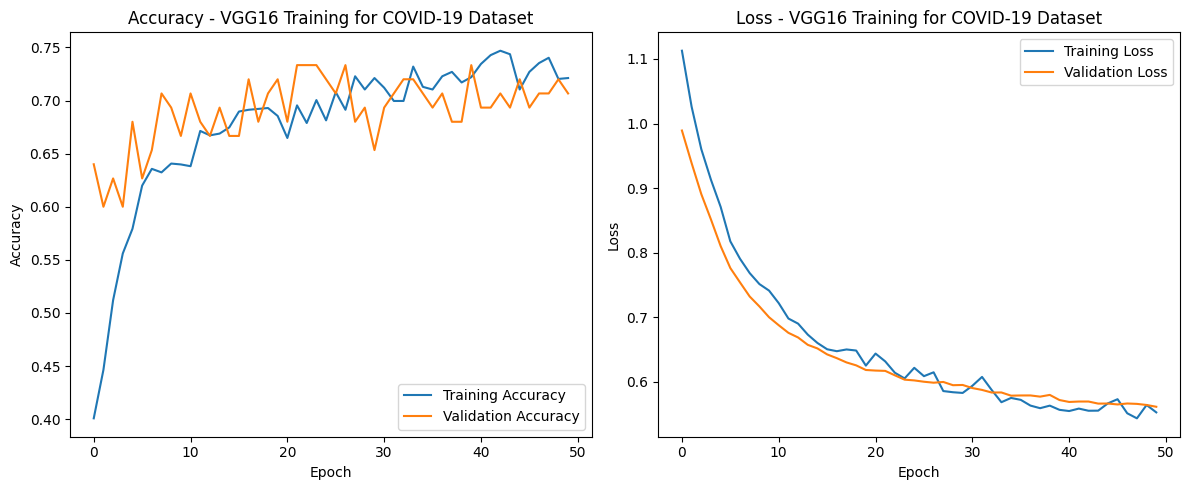

(0.7333333492279053, 0.5616472363471985)

In [13]:
plot_training_history(history, title="VGG16 Training for COVID-19 Dataset")


--- VGG16 Test Evaluation ---
Test Loss: 0.5032, Test Accuracy: 0.8018
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 142ms/step

Classification Report:
              precision    recall  f1-score   support

    Covid-19       0.72      0.76      0.74        76
   Pneumonia       0.73      0.72      0.72        75
      Normal       0.97      0.92      0.95        76

    accuracy                           0.80       227
   macro avg       0.81      0.80      0.80       227
weighted avg       0.81      0.80      0.80       227

Overall Sensitivity (macro-averaged) = 0.8014
Overall Specificity (macro-averaged) = 0.9010


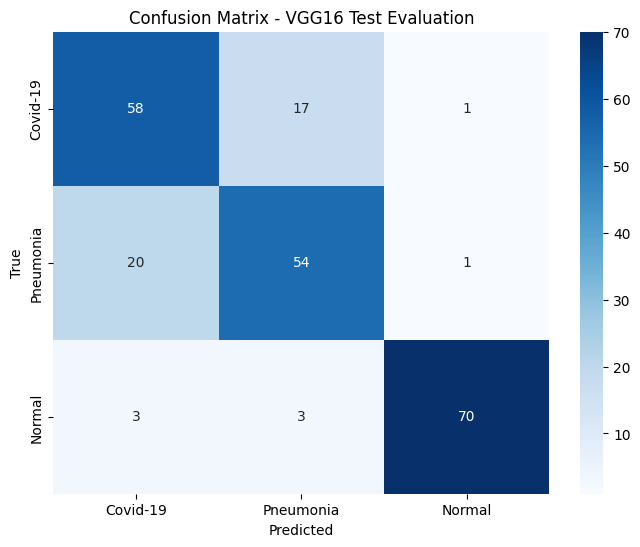

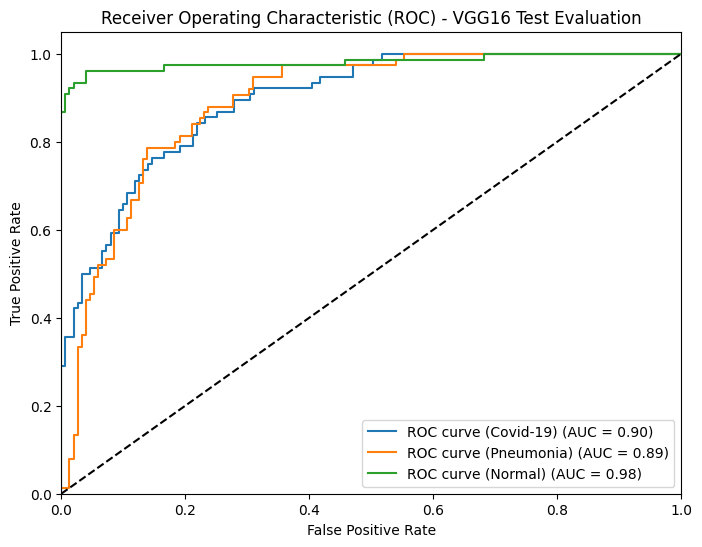

(0.5031793117523193,
 0.8017621040344238,
 0.8014035087719299,
 0.9009527129080981)

In [18]:
evaluate_model(model, test_generator, TARGET_NAMES, title="VGG16 Test Evaluation")

# 5. XAI Helper Functions

In [19]:
def load_and_preprocess_image(image_path, target_size=(224, 224), channels=3):
    """
    Load and preprocess an image for model input.
    Normalizes to [0,1] and expands dims for batch.
    """
    img = Image.open(image_path)
    if channels == 3:
        img = img.convert('RGB')
    else:
        img = img.convert('L')
    
    img = img.resize(target_size)
    img_array = np.array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    return img_array

In [48]:
def deeplift(model, img, baseline=None, pred_index=None):
    """
    Compute DeepLIFT-like feature importance (gradient * input difference).
    Supports single image (H,W,C) or batch (N,H,W,C).
    """
    if baseline is None:
        baseline = np.zeros_like(img)

    # Ensure batch dimension
    if img.ndim == 3:
        img = np.expand_dims(img, 0)
    if baseline.ndim == 3:
        baseline = np.expand_dims(baseline, 0)
    
    img = tf.convert_to_tensor(img, dtype=tf.float32)
    baseline = tf.convert_to_tensor(baseline, dtype=tf.float32)
    
    diff = img - baseline
    
    with tf.GradientTape() as tape:
        tape.watch(img)
        preds = model(img)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        score = preds[:, pred_index]
    
    grads = tape.gradient(score, img)
    contributions = diff * grads
    heatmap = tf.reduce_sum(tf.abs(contributions), axis=-1).numpy()
    
    # If single image, remove batch dimension
    if heatmap.shape[0] == 1:
        heatmap = heatmap[0]

    heatmap = np.maximum(heatmap, 0) / (np.max(heatmap) + 1e-10)
    return heatmap, pred_index


In [21]:
def display_heatmap(img, heatmap, alpha=0.5):
    """
    Overlay heatmap on the original image.
    """
    if img.ndim == 4:
        img = img[0]
    if heatmap.ndim == 3:
        heatmap = heatmap[0]
    
    img_uint8 = np.uint8(255 * (img - img.min()) / (img.max() - img.min() + 1e-10))
    
    heatmap_resized = tf.image.resize(heatmap[..., np.newaxis], (img.shape[0], img.shape[1])).numpy()[..., 0]
    heatmap_uint8 = np.uint8(plt.cm.jet(heatmap_resized)[..., :3] * 255)
    
    superimposed_img = heatmap_uint8 * alpha + img_uint8 * (1 - alpha)
    return np.uint8(superimposed_img)

In [22]:
def permutation_importance(image, model, class_index, num_permutations=50, step_size=24):
    """
    Compute permutation-based feature importance for a single image.
    Returns normalized heatmap.
    """
    image_exp = np.expand_dims(image, axis=0)
    correct_prob = model.predict(image_exp, verbose=0)[0, class_index]

    importance_map = np.zeros((224, 224))
    count_map = np.zeros((224, 224))

    for _ in range(num_permutations):
        i = np.random.randint(0, 224)
        j = np.random.randint(0, 224)

        i_end = min(i + step_size, 224)
        j_end = min(j + step_size, 224)

        perturbed = image.copy()
        perturbed[i:i_end, j:j_end, :] = np.random.rand(i_end - i, j_end - j, 3)

        pred_prob = model.predict(np.expand_dims(perturbed, axis=0), verbose=0)[0, class_index]
        importance = correct_prob - pred_prob
        importance_map[i:i_end, j:j_end] += importance
        count_map[i:i_end, j:j_end] += 1

    importance_map = np.divide(importance_map, count_map, out=np.zeros_like(importance_map), where=count_map != 0)

    if np.max(importance_map) - np.min(importance_map) > 0:
        importance_map = (importance_map - np.min(importance_map)) / (np.max(importance_map) - np.min(importance_map) + 1e-8)
    else:
        importance_map = np.zeros_like(importance_map)

    return importance_map

In [23]:
def draw_heatmaps(images, heatmaps, true_labels, predictions, class_dict, image_paths, labels, alpha=0.5):
    """
    Display original and heatmap overlay images side by side.
    Saves superimposed images as well.
    """
    num_images = len(images)
    plt.figure(figsize=(10, 4 * num_images))
    
    for i in range(num_images):
        # Original image
        plt.subplot(num_images, 2, 2*i + 1)
        plt.imshow(images[i])
        title_pred = class_dict[predictions[i]]
        title_actual = class_dict[true_labels[i]]
        plt.title(f'Predicted: {title_pred}\nActual: {title_actual}')
        plt.axis('off')

        # Overlay heatmap
        plt.subplot(num_images, 2, 2*i + 2)
        plt.imshow(images[i])
        plt.imshow(heatmaps[i], alpha=alpha, cmap='hot')
        plt.title('Feature Importance Overlay')
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

    # Save superimposed images
    for i, (image, heatmap, label, image_path) in enumerate(zip(images, heatmaps, labels, image_paths)):
        superimposed_img = image.copy()
        heatmap_colored = plt.cm.hot(heatmap)[:, :, :3]
        superimposed_img = superimposed_img * (1 - alpha) + heatmap_colored * alpha
        superimposed_img = np.uint8(superimposed_img * 255)

        output_path = f'feature_importance_{label.lower().replace("covid-19","covid19")}_{os.path.basename(image_path)}'
        Image.fromarray(superimposed_img).save(output_path)
        print(f"Saved: {output_path}")

# 6. Single Image Preparation for Grey Wolf XAI

In [26]:
single_image_path = "/kaggle/input/feature-selelcted-dataset/test/covid19/image_195.png"
single_label = "covid19" 

single_image = load_and_preprocess_image(single_image_path, target_size=IMAGE_SIZE, channels=3)
print(f"Single image shape: {single_image.shape}")

single_label_index = LABEL_MAPPING[single_label]
print(f"True class index: {single_label_index}")

Single image shape: (1, 224, 224, 3)
True class index: 0


# 7. Generate Initial XAI Heatmaps

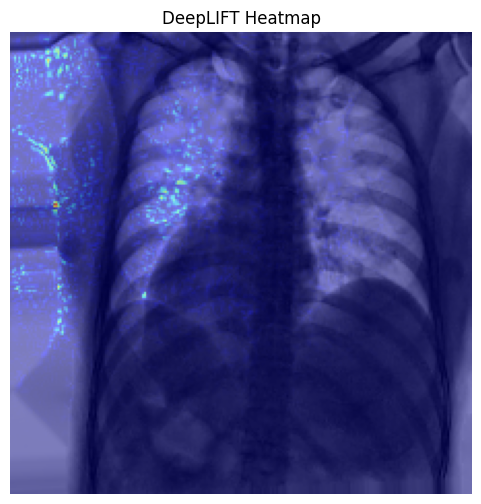

In [27]:
dl_heatmap, dl_pred_index = deeplift(model, single_image, pred_index=single_label_index)
dl_superimposed = display_heatmap(single_image, dl_heatmap, alpha=0.5)

plt.figure(figsize=(6,6))
plt.imshow(dl_superimposed)
plt.title("DeepLIFT Heatmap")
plt.axis('off')
plt.show()

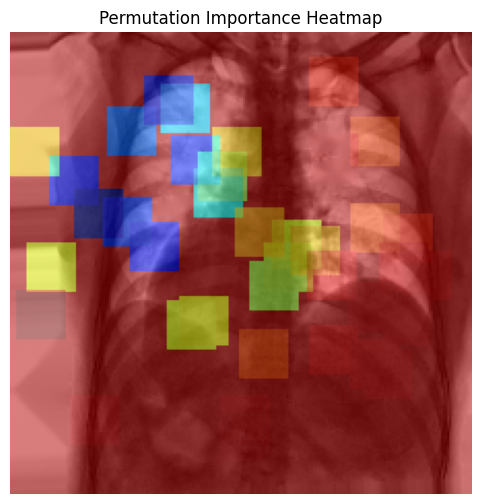

In [28]:
pi_heatmap = permutation_importance(single_image[0], model, class_index=single_label_index, num_permutations=50)
pi_superimposed = display_heatmap(single_image, pi_heatmap, alpha=0.5)

plt.figure(figsize=(6,6))
plt.imshow(pi_superimposed)
plt.title("Permutation Importance Heatmap")
plt.axis('off')
plt.show()

# 8. Grey Wolf XAI Optimization Setup

## 8.1. DeepLIFT Optimization with Gray Wolf Optimizer

In [38]:
def deeplift_contribution(img, model, target_class, mask=None):
    """
    Compute DeepLIFT contribution for a specific class and optional mask.
    """
    baseline = np.zeros_like(img)
    img_tensor = tf.convert_to_tensor(np.expand_dims(img, axis=0), dtype=tf.float32)
    baseline_tensor = tf.convert_to_tensor(np.expand_dims(baseline, axis=0), dtype=tf.float32)
    
    diff = img_tensor - baseline_tensor
    with tf.GradientTape() as tape:
        tape.watch(img_tensor)
        preds = model(img_tensor)
        score = preds[:, target_class]

    grads = tape.gradient(score, img_tensor)
    contributions = diff * grads
    contributions = contributions.numpy()[0]
    
    if mask is not None:
        contributions *= mask  # only consider masked region

    # sum absolute contributions over channels
    score_sum = np.sum(np.abs(contributions))
    return score_sum

In [39]:
def gwo_deeplift_optimization(model, image, target_class, mask=None,
                              population_size=10, max_iter=50, sigma=0.05):
    """
    Optimize an input image to maximize DeepLIFT contribution using Gray Wolf Optimizer.
    
    Returns: best_image, best_score, history
    """
    img_shape = image.shape
    dim = image.size  # flattened size

    # Flatten the image
    wolf_flat = image.flatten()
    
    # Initialize population (wolves)
    wolves = np.array([wolf_flat + np.random.normal(0, sigma, size=wolf_flat.shape)
                       for _ in range(population_size)])
    wolves = np.clip(wolves, 0, 1)

    # Fitness function
    def fitness_fn(candidate_flat):
        candidate_img = candidate_flat.reshape(img_shape)
        return deeplift_contribution(candidate_img, model, target_class, mask=mask)

    # History
    history = []

    # Initialize alpha, beta, delta
    fitness_values = np.array([fitness_fn(w) for w in wolves])
    alpha_idx = np.argmax(fitness_values)
    alpha, alpha_score = wolves[alpha_idx], fitness_values[alpha_idx]

    beta_idx = np.argsort(fitness_values)[-2]
    beta, beta_score = wolves[beta_idx], fitness_values[beta_idx]

    delta_idx = np.argsort(fitness_values)[-3]
    delta, delta_score = wolves[delta_idx], fitness_values[delta_idx]

    # GWO main loop
    for t in range(max_iter):
        a = 2 * (1 - t / max_iter)  # linearly decreasing factor

        for i in range(population_size):
            wolf = wolves[i]

            def update_position(X_leader, wolf):
                r1, r2 = np.random.rand(*wolf.shape), np.random.rand(*wolf.shape)
                A = 2 * a * r1 - a
                C = 2 * r2
                D = np.abs(C * X_leader - wolf)
                return X_leader - A * D

            # Update wolf position
            new_wolf = (update_position(alpha, wolf) +
                        update_position(beta, wolf) +
                        update_position(delta, wolf)) / 3

            # Clip values to valid range
            new_wolf = np.clip(new_wolf, 0, 1)
            wolves[i] = new_wolf

        # Update fitness and leaders
        fitness_values = np.array([fitness_fn(w) for w in wolves])
        alpha_idx = np.argmax(fitness_values)
        alpha, alpha_score = wolves[alpha_idx], fitness_values[alpha_idx]

        beta_idx = np.argsort(fitness_values)[-2]
        beta, beta_score = wolves[beta_idx], fitness_values[beta_idx]

        delta_idx = np.argsort(fitness_values)[-3]
        delta, delta_score = wolves[delta_idx], fitness_values[delta_idx]

        history.append(alpha_score)
        print(f"Iteration {t+1}/{max_iter} | Best DeepLIFT Score: {alpha_score:.6f}")

    best_wolf = alpha.reshape(img_shape)
    return best_wolf, alpha_score, history

## 8.2. Permutation Importance Optimization with Gray Wolf Optimizer

In [53]:
def permutation_importance_score(model, img, target_class, mask=None, metric='prob'):
    """
    Compute local permutation importance score for a single image.
    - mask: region to perturb (1=keep, 0=perturb)
    - metric: 'prob' for target class probability drop
    Returns: importance score (higher means feature is important)
    """
    img = np.array(img, dtype=np.float32)
    if mask is None:
        mask = np.ones_like(img)

    # original prediction
    img_input = np.expand_dims(img, 0)
    original_probs = model.predict(img_input, verbose=0)
    original_score = original_probs[0, target_class]

    # permute the masked region: add small Gaussian noise
    noisy_img = img.copy()
    noise = np.random.normal(0, 0.05, img.shape)
    noisy_img[mask==0] += noise[mask==0]
    noisy_img = np.clip(noisy_img, 0, 1)

    noisy_input = np.expand_dims(noisy_img, 0)
    new_probs = model.predict(noisy_input, verbose=0)
    new_score = new_probs[0, target_class]

    # importance = drop in target class score
    importance = original_score - new_score
    return importance


In [54]:
# 8.1 Permutation Importance Fitness
def permutation_fitness(image, model, target_class, mask=None):
    """
    Compute local permutation importance score.
    """
    orig_prob = model.predict(np.expand_dims(image, axis=0), verbose=0)[0, target_class]
    
    permuted_img = image.copy()
    if mask is None:
        mask = np.ones_like(image)
    # Shuffle masked pixels
    permuted_img[mask==1] = np.random.permutation(permuted_img[mask==1])
    
    new_prob = model.predict(np.expand_dims(permuted_img, axis=0), verbose=0)[0, target_class]
    return orig_prob - new_prob

def gwo_permutation_importance(model, image, target_class, mask=None,
                               population_size=10, max_iter=50, sigma=0.05):
    """
    Optimize an input image to maximize permutation importance for a given feature/region.
    """
    img_shape = image.shape
    flat_img = image.flatten()

    # Initialize population: small perturbations around original image
    wolves = [flat_img + np.random.normal(0, sigma, flat_img.shape) for _ in range(population_size)]
    wolves = [np.clip(w, 0, 1) for w in wolves]

    # Fitness function: drop in target class score
    def fitness_fn(candidate_flat):
        candidate_img = candidate_flat.reshape(img_shape)
        return permutation_importance_score(model, candidate_img, target_class, mask=mask)

    # Initialize alpha, beta, delta
    fitness_values = np.array([fitness_fn(w) for w in wolves])
    alpha_idx = np.argmax(fitness_values)
    alpha, alpha_score = wolves[alpha_idx], fitness_values[alpha_idx]

    beta_idx = np.argsort(fitness_values)[-2]
    beta, beta_score = wolves[beta_idx], fitness_values[beta_idx]

    delta_idx = np.argsort(fitness_values)[-3]
    delta, delta_score = wolves[delta_idx], fitness_values[delta_idx]

    history = [alpha_score]

    for t in range(max_iter):
        a = 2 - 2 * (t / max_iter)
        for i, wolf in enumerate(wolves):
            r1, r2 = np.random.rand(), np.random.rand()
            A1 = 2 * a * r1 - a
            C1 = 2 * r2
            D_alpha = np.abs(C1 * alpha - wolf)
            X1 = alpha - A1 * D_alpha

            r1, r2 = np.random.rand(), np.random.rand()
            A2 = 2 * a * r1 - a
            C2 = 2 * r2
            D_beta = np.abs(C2 * beta - wolf)
            X2 = beta - A2 * D_beta

            r1, r2 = np.random.rand(), np.random.rand()
            A3 = 2 * a * r1 - a
            C3 = 2 * r2
            D_delta = np.abs(C3 * delta - wolf)
            X3 = delta - A3 * D_delta

            new_wolf = (X1 + X2 + X3) / 3
            new_wolf = np.clip(new_wolf, 0, 1)
            wolves[i] = new_wolf

        # Update alpha, beta, delta
        fitness_values = np.array([fitness_fn(w) for w in wolves])
        alpha_idx = np.argmax(fitness_values)
        alpha, alpha_score = wolves[alpha_idx], fitness_values[alpha_idx]

        beta_idx = np.argsort(fitness_values)[-2]
        beta, beta_score = wolves[beta_idx], fitness_values[beta_idx]

        delta_idx = np.argsort(fitness_values)[-3]
        delta, delta_score = wolves[delta_idx], fitness_values[delta_idx]

        history.append(alpha_score)

    optimized_image = alpha.reshape(img_shape)
    return optimized_image, alpha_score, history

Iteration 1/50 | Best DeepLIFT Score: 54.751942
Iteration 2/50 | Best DeepLIFT Score: 46.071220
Iteration 3/50 | Best DeepLIFT Score: 41.864037
Iteration 4/50 | Best DeepLIFT Score: 36.294868
Iteration 5/50 | Best DeepLIFT Score: 29.111366
Iteration 6/50 | Best DeepLIFT Score: 28.852106
Iteration 7/50 | Best DeepLIFT Score: 28.404274
Iteration 8/50 | Best DeepLIFT Score: 23.640305
Iteration 9/50 | Best DeepLIFT Score: 21.348618
Iteration 10/50 | Best DeepLIFT Score: 18.455008
Iteration 11/50 | Best DeepLIFT Score: 15.632154
Iteration 12/50 | Best DeepLIFT Score: 18.044727
Iteration 13/50 | Best DeepLIFT Score: 14.198851
Iteration 14/50 | Best DeepLIFT Score: 13.232080
Iteration 15/50 | Best DeepLIFT Score: 12.499475
Iteration 16/50 | Best DeepLIFT Score: 13.808750
Iteration 17/50 | Best DeepLIFT Score: 13.009689
Iteration 18/50 | Best DeepLIFT Score: 13.394596
Iteration 19/50 | Best DeepLIFT Score: 12.853935
Iteration 20/50 | Best DeepLIFT Score: 13.474081
Iteration 21/50 | Best DeepLI

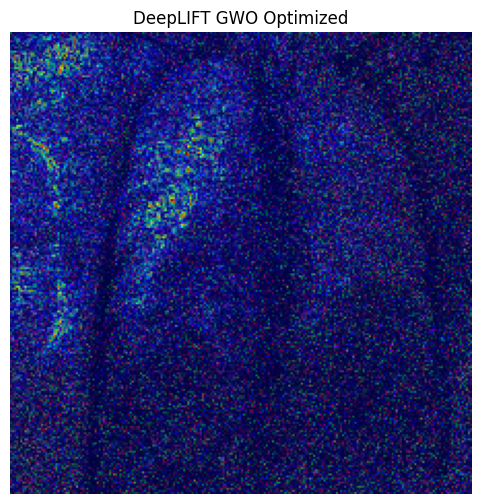

In [51]:
# Step 1: Compute initial DeepLIFT heatmap for original image
initial_heatmap, _ = deeplift(model, np.expand_dims(single_image[0], 0), pred_index=single_label_index)

# Step 2: Set mask for full image
mask = np.ones((224,224,3))  # can later specify smaller region

# Step 3: Run GWO DeepLIFT optimization
optimized_image, best_score, history = gwo_deeplift_optimization(
    model,
    single_image[0],  # shape (224,224,3)
    target_class=single_label_index,
    mask=mask,
    population_size=10,
    max_iter=50
)

# Step 4: Visualize optimized heatmap overlay
plt.figure(figsize=(6,6))
plt.imshow(display_heatmap(np.expand_dims(optimized_image,0), initial_heatmap, alpha=0.5))
plt.title("DeepLIFT GWO Optimized")
plt.axis('off')
plt.show()

Best Permutation Importance score achieved: 0.0


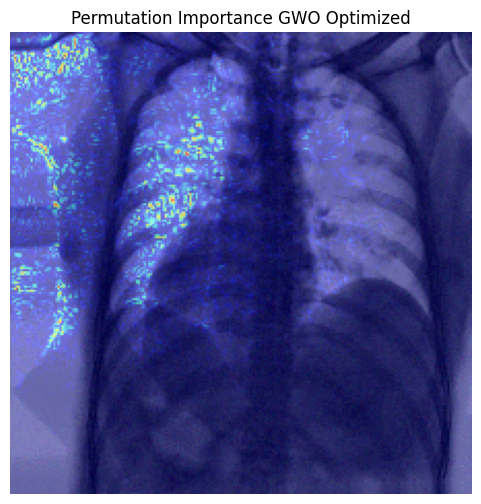

In [57]:
mask = np.ones((224,224,3))  # full image
optimized_image_pi, best_score_pi, history_pi = gwo_permutation_importance(
    model,
    single_image[0],
    target_class=single_label_index,
    mask=mask,
    population_size=10,
    max_iter=50
)

print("Best Permutation Importance score achieved:", best_score_pi)

plt.figure(figsize=(6,6))
plt.imshow(display_heatmap(np.expand_dims(optimized_image_pi,0), initial_heatmap, alpha=0.5))
plt.title("Permutation Importance GWO Optimized")
plt.axis('off')
plt.show()